# Obtener información de las imagenes del dataset Camelyon16

## Inicializar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_folder = "/content/drive/MyDrive/00 VIU/10 TFM/"

Mounted at /content/drive


In [ ]:
!pip install openslide-python -qqq
!pip install openslide-bin -qqq
!apt-get install openslide-tools -qqq
!pip install awscli

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 34.0 MB/s eta 0:00:00
Selecting previously unselected package libopenslide0.
(Reading database ... 126281 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-5build1) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack .../openslide-tools_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking openslide-tools (3.4.1+dfsg-5build1) ...
Setting up libopenslide0 (3.4.1+dfsg-5build1) ...
Setting up openslide-tools (3.4.1+dfsg-5build1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.8) ...
/sbin/ldconfig.real: /usr/local/lib/libhwloc.so.15 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libumf.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_level_zero.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is no

In [ ]:
import os
import openslide
import subprocess
from PIL import Image
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


## Extraer el listado de imágenes

In [ ]:
!aws s3 ls --no-sign-request s3://camelyon-dataset/CAMELYON17/images/ --human-readable >imagenes.txt

In [ ]:
df_images = pd.read_csv('imagenes.txt', header=None, sep=' ', skipinitialspace=True, names=["fecha","hora","tamano","unids","nombre"])
display(df_images.head())

,fecha,hora,tamano,unids,nombre
0,2022-09-28,12:49:33,2.6,GiB,patient_000_node_0.tif
1,2022-09-28,12:50:15,2.1,GiB,patient_000_node_1.tif
2,2022-09-28,12:50:50,2.1,GiB,patient_000_node_2.tif
3,2022-09-28,12:51:34,2.1,GiB,patient_000_node_3.tif
4,2022-09-28,12:51:34,1.8,GiB,patient_000_node_4.tif


## Leer uno a uno los archivos del bucket AWS y extraer información

In [ ]:
%%time
s3_url_dir  = "s3://camelyon-dataset/CAMELYON17/images/"
# lista_dimensiones, lista_levels, lista_nombres, gray_mean = [],[],[],[]
variables = pickle.load(open(base_folder+'variables 150725 0244.pkl', 'rb'))
lista_dimensiones = variables['dimensiones']
gray_mean = variables['gray_mean']
lista_nombres = variables['nombres']
for index, row in df_images.iterrows():
    if index<631:
      continue
    s3_url = s3_url_dir + row["nombre"]
    local_path = row["nombre"]
    #Copiar el archivo:
    try:
        subprocess.run(["aws", "s3", "cp", "--no-sign-request", s3_url, local_path], check=True)
        print(f"Archivo '{s3_url}' descargado exitosamente a '{local_path}'.",end=";")
        if os.path.exists(local_path):
         try:
            slide = openslide.OpenSlide(local_path)
            print(" procesado ok.")
            lista_nombres.append(row["nombre"])
            lista_dimensiones.append(slide.dimensions)
            levels = slide.level_count
            # lista_levels.append(levels)
            img = slide.read_region((0, 0), levels-1, slide.level_dimensions[levels-1])
            img_array = np.array(img)
            img_gray= np.array(Image.fromarray(img_array).convert('L'))
            gray_mean.append(int(np.mean(img_gray)))

            slide.close()

         except openslide.OpenSlideError as e:
            print(f"Error de OpenSlide al abrir el archivo local: {e}")
         os.remove(local_path)
        else:
         print("El archivo no se descargó")

    except subprocess.CalledProcessError as e:
      print(f"Error al descargar el archivo: {e}")
      print(f"Asegúrate de que awscli esté instalado y configurado, o que la URL S3 sea correcta.")
    if index %10 == 0:
     with open(base_folder+'variables.pkl', 'wb') as f:
      pickle.dump({'dimensiones': lista_dimensiones, 'gray_mean': gray_mean, 'nombres':lista_nombres}, f)

Archivo 's3://camelyon-dataset/CAMELYON17/images/patient_126_node_3.tif' descargado exitosamente a 'patient_126_node_3.tif'.; procesado ok.
Archivo 's3://camelyon-dataset/CAMELYON17/images/patient_126_node_4.tif' descargado exitosamente a 'patient_126_node_4.tif'.; procesado ok.
Archivo 's3://camelyon-dataset/CAMELYON17/images/patient_127_node_0.tif' descargado exitosamente a 'patient_127_node_0.tif'.; procesado ok.
Archivo 's3://camelyon-dataset/CAMELYON17/images/patient_127_node_1.tif' descargado exitosamente a 'patient_127_node_1.tif'.; procesado ok.
Archivo 's3://camelyon-dataset/CAMELYON17/images/patient_127_node_2.tif' descargado exitosamente a 'patient_127_node_2.tif'.; procesado ok.
Archivo 's3://camelyon-dataset/CAMELYON17/images/patient_127_node_3.tif' descargado exitosamente a 'patient_127_node_3.tif'.; procesado ok.
Archivo 's3://camelyon-dataset/CAMELYON17/images/patient_127_node_4.tif' descargado exitosamente a 'patient_127_node_4.tif'.; procesado ok.
Archivo 's3://camely

In [ ]:
print("finalizado")
print("imágenes: ",len(lista_dimensiones))
with open(base_folder+'variables.pkl', 'wb') as f:
  pickle.dump({'dimensiones': lista_dimensiones, 'gray_mean': gray_mean, 'nombres':lista_nombres}, f)

finalizado
imágenes:  998


## Análisis de luminosidad - Histograma

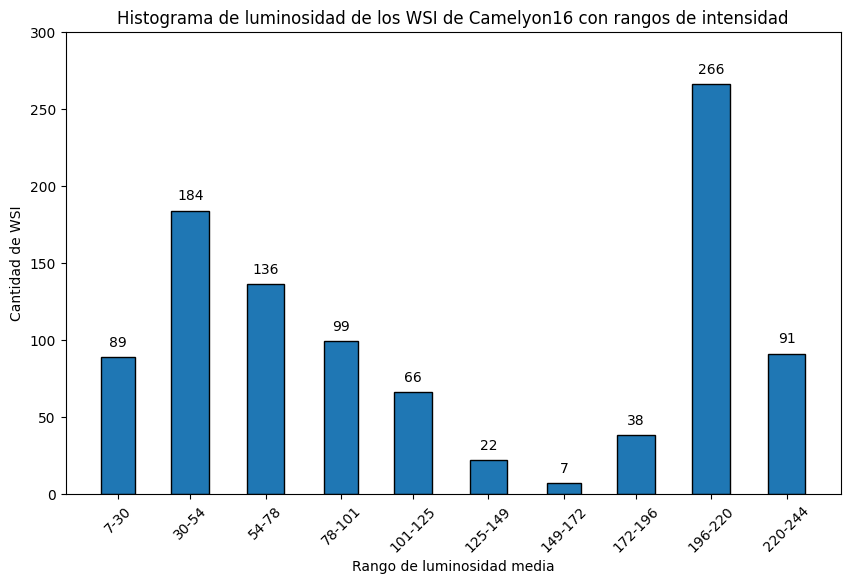

In [ ]:
hist, bins = np.histogram(gray_mean, bins=10)
bins = [ int(x) for x in bins]

plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], hist, width=np.diff(bins)//2, edgecolor='black')

# Anotaciones:
for i, count in enumerate(hist):
    plt.text(bins[i], count + 5, str(count), ha='center', va='bottom')

# xticks
bin_centers = bins[:-1]
bin_labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]
plt.xticks(bin_centers, bin_labels, rotation=45)

plt.xlabel('Rango de luminosidad media')
plt.ylabel('Cantidad de WSI')
plt.ylim(0, 300)
plt.title('Histograma de luminosidad de los WSI de Camelyon16 con rangos de intensidad')
plt.show()

In [ ]:
promedio_intensidad = sum(gray_mean)/len(gray_mean)
print(f"Promedio de los valores de intensidad: {promedio_intensidad:.1f}")
print(f"Cantidad de imágenes: {len(gray_mean)}")

Promedio de los valores de intensidad: 123.6
Cantidad de imágenes: 998


## Visualización WSI de menor luminosidad

In [ ]:
# Identificar WSI del percentil más bajo para visualizarlas
percentile_10 = np.percentile(gray_mean, 10)
indices_decil_0 = [i for i, value in enumerate(gray_mean) if value <= percentile_10]
print("Índices de los elementos en el decil más bajo:", indices_decil_0[:10]," ...")


Índices de los elementos en el decil más bajo: [2, 3, 4, 6, 7, 9, 15, 17, 20, 21]  ...


In [ ]:
# Preparar lista de nombres de WSI del decil más bajo
lista_imgs_decil0,lista_int_decil0=[],[]
for i in indices_decil_0:
    lista_imgs_decil0.append(lista_nombres[i])
    lista_int_decil0.append(gray_mean[i])


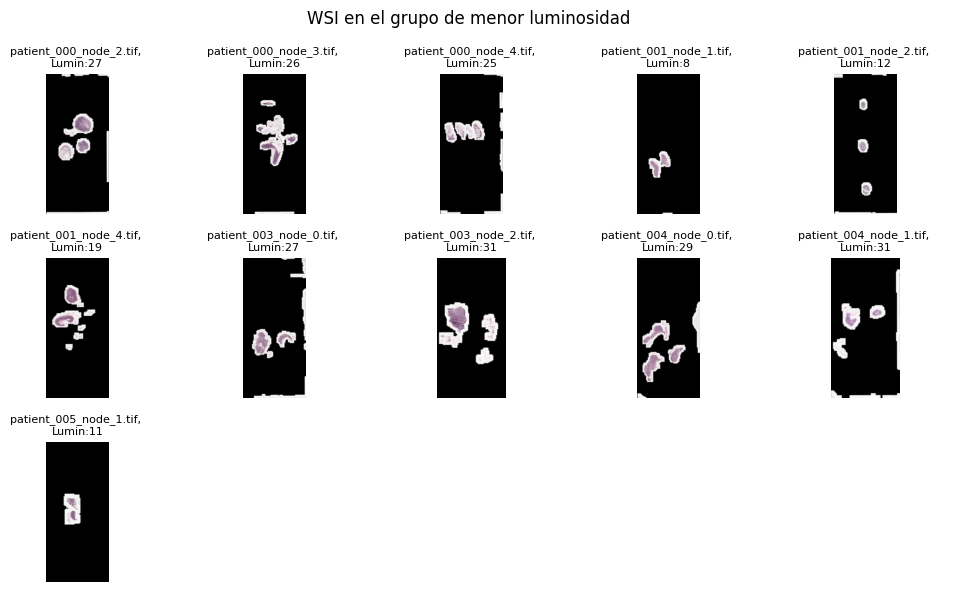

In [ ]:
# Visualizar los thumbs de los WSI del decil más bajo
images_to_display = []
titles_to_display = []
max_images = 10

for i, elemento in enumerate(lista_imgs_decil0):
  try:
    # Leer en AWS y hacer una copia en el almacenamiento del entorno de ejecución:
    tit = f"{elemento}, \nLumin:{lista_int_decil0[i]}"
    local_path=elemento
    s3_url = s3_url_dir + elemento
    subprocess.run(["aws", "s3", "cp", "--no-sign-request", s3_url, local_path], check=True)
    # Cargar el WSI (lazy load):
    slide = openslide.OpenSlide(local_path)
    images_to_display.append(slide.get_thumbnail((256, 256)))
    titles_to_display.append(tit)
    os.remove(local_path)
    if len(images_to_display) > max_images:
        break

  except ValueError:
    print("error al copiar o leer el slide")

n_cols = 5
n_rows = (len(images_to_display) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
axes = axes.flatten()

for i, (img, title) in enumerate(zip(images_to_display, titles_to_display)):
    axes[i].imshow(img)
    axes[i].set_title(title, fontsize=8)
    axes[i].axis('off')

# Ocultar subplots sobrantes:
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# plt.tight_layout()
fig.suptitle('WSI en el grupo de menor luminosidad ')
plt.tight_layout()
# plt.savefig(nom_archivo_img_bin1)
plt.show()



## Análisis de tamaño - Histograma

In [ ]:
tipo_unid = np.unique(np.array(df_images['unids']),return_counts=True)
print(tipo_unid)

(array(['GiB', 'MiB'], dtype=object), array([854, 144]))


In [ ]:
df2 = df_images.copy()

In [ ]:
# Convertir a Gigabytes los datos que están en Megabytes:
mib_rows = df2['unids'] == 'MiB'
df2.loc[mib_rows, 'tamano'] = df2.loc[mib_rows, 'tamano'] / 1024
df2.loc[mib_rows, 'unids'] = 'GiB'
display(df2.loc[mib_rows].head())

,fecha,hora,tamano,unids,nombre
216,2022-09-28,16:13:46,0.634570,GiB,patient_043_node_1.tif
219,2022-09-28,16:15:27,0.877344,GiB,patient_043_node_4.tif
252,2022-09-28,16:43:07,0.964648,GiB,patient_050_node_2.tif
268,2022-09-28,16:57:42,0.567969,GiB,patient_053_node_4.tif
400,2022-09-28,18:57:54,0.815234,GiB,patient_080_node_1.tif


Promedio de tamaño: 2.8 GB
WSI de mayor tamaño: 8.7 GB
WSI de menor tamaño: 0.2 GB
Almacenamiento total requerido para el dataset: 2760.9 GB


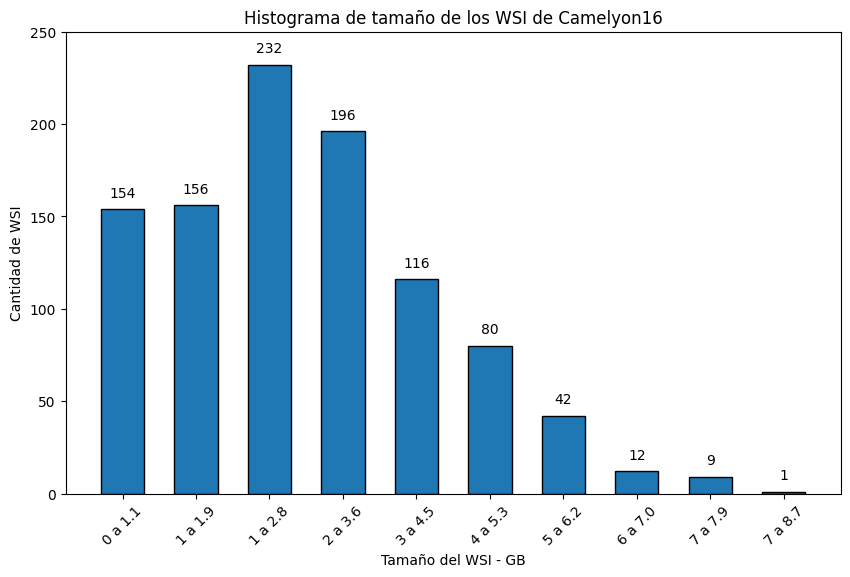

In [ ]:
print(f"Promedio de tamaño: {df2['tamano'].mean():.1f} GB")
print(f"WSI de mayor tamaño: {df2['tamano'].max():.1f} GB")
print(f"WSI de menor tamaño: {df2['tamano'].min():.1f} GB")
print(f"Almacenamiento total requerido para el dataset: {df2['tamano'].sum():.1f} GB")
# histograma de tamaño
cant,bins=np.histogram(df2['tamano'],bins=10)
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], cant, width=0.5, edgecolor='black')

# Anotaciones:
for i, count in enumerate(cant):
    plt.text(bins[i], count + 5, str(count), ha='center', va='bottom')

# xticks
bin_centers = bins[:-1]
bin_labels = [f'{int(bins[i])} a {bins[i+1]:.1f}' for i in range(len(bins)-1)]
plt.xticks(bin_centers, bin_labels, rotation=45)

plt.xlabel('Tamaño del WSI - GB')
plt.ylabel('Cantidad de WSI')
plt.ylim(0, 250)
plt.title('Histograma de tamaño de los WSI de Camelyon16')
plt.show()